In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import datetime as dt
import dask.dataframe as dd

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches
from pathlib import Path

In [2]:
import sys

sys.path.append("../src")

In [3]:
from core import SITE_NAMES, EXAMPLE_FILES_from_LOCATIONS, EXAMPLE_FILES_to_FILEPATHS, EXAMPLE_FILES_to_DETECTIONS
import bout_clustering as bt_clustering
import bout_plotting as bt_plt
import subsampling as ss
import data_handling as dh

from cli import get_file_paths

In [6]:
site_key = 'Central'
freq_key = ''
files = EXAMPLE_FILES_from_LOCATIONS[site_key]
thresh = -10
line_color = 'navy'
line_alpha = 0.002
reduce = 50
data_params = dict()
data_params["site_name"] = SITE_NAMES[site_key]
data_params["site_tag"] = site_key
data_params["type_tag"] = freq_key
data_params["dc_tag"] = "1800of1800"
data_params["cur_dc_tag"] = "1800of1800"

spec_features = dict()
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'
fs = 192000

file_paths = get_file_paths(data_params)


central_example_bout_metrics = pd.DataFrame()
# for filepath_key in files:
filepath_key = files[0]
print(filepath_key)
filename = filepath_key.split('/')[-1]
file_path = Path(EXAMPLE_FILES_to_FILEPATHS[filepath_key])
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate

csv_path = Path(EXAMPLE_FILES_to_DETECTIONS[filepath_key])
batdetect2_predictions_no_dutycycle = dh.assemble_single_bd2_output(csv_path, data_params)
batdetect2_predictions = ss.simulate_dutycycle_on_detections(batdetect2_predictions_no_dutycycle, data_params['cur_dc_tag'])
location_sum_df = dh.assemble_initial_location_summary(data_params, file_paths) 
bout_params = bt_clustering.get_bout_params_from_location(location_sum_df, data_params)
batdetect2_preds_with_bouttags = bt_clustering.classify_bouts_in_bd2_predictions_for_freqgroups(batdetect2_predictions, bout_params)
bout_metrics = bt_clustering.construct_bout_metrics_from_location_df_for_freqgroups(batdetect2_preds_with_bouttags)

UBNA_010/20220826_043000


In [7]:
activated = []
for i, row in bout_metrics.iterrows():
#########################################################################################
    ############### BELOW WE READ IN THE BOUT IN THE AUDIO WE ARE CONSIDERING ###############
    #########################################################################################

    start = row['start_time'] - 0.02
    end = row['end_time'] + 0.02

    group = row['freq_group']
    freq_group = batdetect2_predictions.loc[batdetect2_predictions['freq_group']==group]
    bat_bout = freq_group.loc[(freq_group['start_time']>=start)&(freq_group['end_time']<=end)].copy()
    call_snrs = []
    for i, row in bat_bout.iterrows():
        ########################################################################################################
        ############### BELOW WE READ IN THE WINDOW OF DETECTION OF THE AUDIO WE ARE CONSIDERING ###############
        ########################################################################################################

        start = row['start_time'] - 0.02
        end = row['start_time'] + 0.03
        if start >=0 and end <= 1795:
            duration = end - start
            audio_file.seek(int(fs*start))
            audio_seg = audio_file.read(int(fs*duration))
            spec_features['NFFT'] = 256
            spec_features['cmap'] = 'jet'

        ################################################################################################
        ############### BELOW WE APPLY A BANDPASS FILTER ON THE AUDIO WE ARE CONSIDERING ###############
        ################################################################################################

            if row['high_freq']+2000 < fs/2:
                nyq = 0.5 * fs
                low_cutoff = (row['low_freq'] - 2000)/ nyq
                high_cutoff =  (row['high_freq'] + 2000) / nyq
                b, a = scipy.signal.butter(5, [low_cutoff, high_cutoff], btype='band', analog=False)
                band_limited_audio_seg = scipy.signal.filtfilt(b, a, audio_seg)
                vmin = 20*np.log10(np.max(band_limited_audio_seg)) - 40 # hide anything below -rm_dB dB

                ####################################################################################################
                ############### BELOW WE GET THE SNR BY SUBTRACTING THE CALL FROM ITS ORIGINAL AUDIO ###############
                ####################################################################################################

                cleaned_call_signal = band_limited_audio_seg[int(fs*0.020):-int(fs*0.020)]
                signal = band_limited_audio_seg.copy()
                signal[:int(fs*0.02)] = 0
                signal[-int(fs*0.02):] = 0

                noise = audio_seg - signal
                signal_power = np.square(cleaned_call_signal).mean()
                noise_power = np.square(noise).mean()
                snr = abs(20 * np.log10(signal_power / noise_power))
                call_snrs += [snr]
            else:
                call_snrs += [np.NaN]
        else:
            call_snrs += [np.NaN]

    bat_bout['SNR'] = call_snrs
    top_10_SNR =  0.90*bat_bout['SNR'].max()

    bucket = np.zeros(int(0.05*fs/2))
    for i, row in bat_bout.iterrows():
        ########################################################################################################
        ############### BELOW WE READ IN THE CALL IN THE AUDIO WE ARE CONSIDERING ###############
        ########################################################################################################

        if row['SNR'] >= top_10_SNR:
            start = row['start_time'] - 0.02
            end = row['start_time'] + 0.03
            duration = end - start
            audio_file.seek(int(fs*start))
            audio_seg = audio_file.read(int(fs*duration))
            spec_features['NFFT'] = 256
            spec_features['cmap'] = 'jet'

            ################################################################################################
            ############### BELOW WE APPLY A BANDPASS FILTER ON THE AUDIO WE ARE CONSIDERING ###############
            ################################################################################################

            nyq = 0.5 * fs
            low_cutoff = (row['low_freq'] - 2000)/ nyq
            high_cutoff =  (row['high_freq'] + 2000) / nyq
            b, a = scipy.signal.butter(5, [low_cutoff, high_cutoff], btype='band', analog=False)
            band_limited_audio_seg = scipy.signal.filtfilt(b, a, audio_seg)
            vmin = 20*np.log10(np.max(band_limited_audio_seg)) - 40 # hide anything below -rm_dB dB

            audio_spectrum = scipy.fft.rfft(band_limited_audio_seg)
            audio_spectrum = np.abs(audio_spectrum)
            time_of_signal = np.arange(0, duration*fs/2)
            audio_spectrum_db =  20*np.log10(audio_spectrum)
            normalized_audio_spectrum_db = audio_spectrum_db - audio_spectrum_db.max()

            thresh = -10
            peak_db = np.zeros(len(normalized_audio_spectrum_db))+thresh
            peak_db[normalized_audio_spectrum_db>=thresh] = normalized_audio_spectrum_db[normalized_audio_spectrum_db>=thresh]

            bucket += peak_db[0:len(bucket)]

    samples = np.arange(0, len(bucket))
    activated_frequencies = (samples[bucket>-10*len(bat_bout.loc[bat_bout['SNR'] >= top_10_SNR])])/duration
    lowest_activated = activated_frequencies[0]
    highest_activated = activated_frequencies[-1]
    activated += [(lowest_activated, highest_activated)]

bout_metrics['activated_frequencies'] = activated
central_example_bout_metrics = pd.concat([central_example_bout_metrics, bout_metrics])

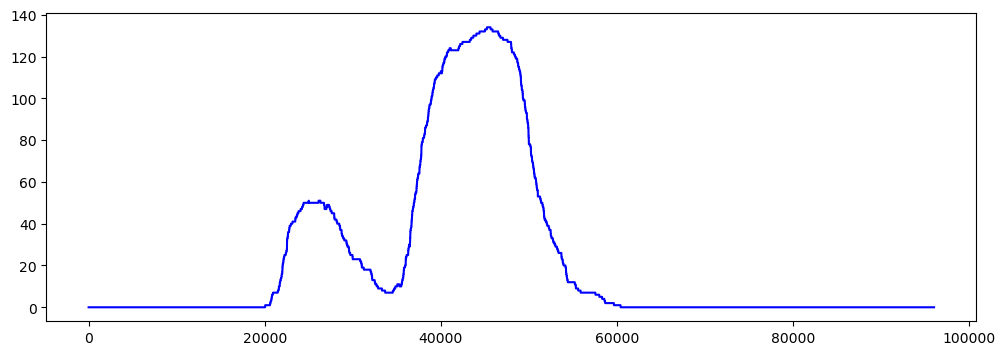

In [8]:
plt.figure(figsize=(12, 4))
bucket = np.zeros(fs//2)
for i, row in central_example_bout_metrics[::].iterrows():
    x = np.arange(fs//2)
    y = np.zeros(fs//2)
    y[int(row['activated_frequencies'][0]):int(row['activated_frequencies'][1])] = 1
    bucket += y

plt.plot(x, bucket, color='blue', alpha = 1)
plt.show()

In [115]:
activated = []
bout_index = 0
row = bout_metrics.iloc[bout_index]
#########################################################################################
############### BELOW WE READ IN THE BOUT IN THE AUDIO WE ARE CONSIDERING ###############
#########################################################################################

start = row['start_time'] - 0.02
end = row['end_time'] + 0.02

group = row['freq_group']
freq_group = batdetect2_predictions.loc[batdetect2_predictions['freq_group']==group]
bat_bout = freq_group.loc[(freq_group['start_time']>=start)&(freq_group['end_time']<=end)].copy()
bat_bout_condensed = pd.DataFrame()
bucket = []

In [116]:
call_snrs = []
for i, row in bat_bout.iterrows():
    ########################################################################################################
    ############### BELOW WE READ IN THE WINDOW OF DETECTION OF THE AUDIO WE ARE CONSIDERING ###############
    ########################################################################################################

    start = row['start_time'] - 0.02
    end = row['start_time'] + 0.03
    if start >=0 and end <= 1795:
        duration = end - start
        audio_file.seek(int(fs*start))
        audio_seg = audio_file.read(int(fs*duration))
        spec_features['NFFT'] = 256
        spec_features['cmap'] = 'jet'

    ################################################################################################
    ############### BELOW WE APPLY A BANDPASS FILTER ON THE AUDIO WE ARE CONSIDERING ###############
    ################################################################################################

        if row['high_freq']+2000 < fs/2:
            nyq = 0.5 * fs
            low_cutoff = (row['low_freq'] - 2000)/ nyq
            high_cutoff =  (row['high_freq'] + 2000) / nyq
            b, a = scipy.signal.butter(5, [low_cutoff, high_cutoff], btype='band', analog=False)
            band_limited_audio_seg = scipy.signal.filtfilt(b, a, audio_seg)
            vmin = 20*np.log10(np.max(band_limited_audio_seg)) - 40 # hide anything below -rm_dB dB

            ####################################################################################################
            ############### BELOW WE GET THE SNR BY SUBTRACTING THE CALL FROM ITS ORIGINAL AUDIO ###############
            ####################################################################################################

            cleaned_call_signal = band_limited_audio_seg[int(fs*0.020):-int(fs*0.020)]
            signal = band_limited_audio_seg.copy()
            signal[:int(fs*0.02)] = 0
            signal[-int(fs*0.02):] = 0

            noise = audio_seg - signal
            signal_power = np.square(cleaned_call_signal).mean()
            noise_power = np.square(noise).mean()
            snr = abs(20 * np.log10(signal_power / noise_power))
            call_snrs += [snr]

            audio_spectrum = scipy.fft.rfft(band_limited_audio_seg)
            audio_spectrum = np.abs(audio_spectrum)
            time_of_signal = np.arange(0, duration*fs/2)
            audio_spectrum_db =  20*np.log10(audio_spectrum)
            normalized_audio_spectrum_db = audio_spectrum_db - audio_spectrum_db.max()

            thresh = -10
            peak_db = np.zeros(len(normalized_audio_spectrum_db))+thresh
            peak_db[normalized_audio_spectrum_db>=thresh] = normalized_audio_spectrum_db[normalized_audio_spectrum_db>=thresh]

            bucket.append(peak_db[:int(0.05*fs/2)])
        else:
            call_snrs += [np.NaN]
    else:
        call_snrs += [np.NaN]

bat_bout['SNR'] = call_snrs
top_10_SNR =  0.90*bat_bout['SNR'].max()

In [117]:
bucket = np.vstack(bucket)
bucket

array([[-10., -10., -10., ..., -10., -10., -10.],
       [-10., -10., -10., ..., -10., -10., -10.],
       [-10., -10., -10., ..., -10., -10., -10.],
       ...,
       [-10., -10., -10., ..., -10., -10., -10.],
       [-10., -10., -10., ..., -10., -10., -10.],
       [-10., -10., -10., ..., -10., -10., -10.]])

In [91]:
(bucket)

[array([-10., -10., -10., ..., -10., -10., -10.]),
 array([-10., -10., -10., ..., -10., -10., -10.]),
 array([-10., -10., -10., ..., -10., -10., -10.]),
 array([-10., -10., -10., ..., -10., -10., -10.]),
 array([-10., -10., -10., ..., -10., -10., -10.]),
 array([-10., -10., -10., ..., -10., -10., -10.]),
 array([-10., -10., -10., ..., -10., -10., -10.]),
 array([-10., -10., -10., ..., -10., -10., -10.]),
 array([-10., -10., -10., ..., -10., -10., -10.]),
 array([-10., -10., -10., ..., -10., -10., -10.]),
 array([-10., -10., -10., ..., -10., -10., -10.]),
 array([-10., -10., -10., ..., -10., -10., -10.]),
 array([-10., -10., -10., ..., -10., -10., -10.]),
 array([-10., -10., -10., ..., -10., -10., -10.]),
 array([-10., -10., -10., ..., -10., -10., -10.]),
 array([-10., -10., -10., ..., -10., -10., -10.]),
 array([-10., -10., -10., ..., -10., -10., -10.]),
 array([-10., -10., -10., ..., -10., -10., -10.]),
 array([-10., -10., -10., ..., -10., -10., -10.]),
 array([-10., -10., -10., ..., 

In [ ]:
samples = np.arange(0, len(bucket))
activated_frequencies = (samples[bucket>-10*len(bat_bout.loc[bat_bout['SNR'] >= top_10_SNR])])/duration
lowest_activated = activated_frequencies[0]
highest_activated = activated_frequencies[-1]
activated += [(lowest_activated, highest_activated)]

bout_metrics

In [61]:
bat_bout.insert(0, 'activated_frequencies', [activated[0]] * len(bat_bout))
bat_bout.insert(0, 'call_index', bat_bout.index)
bat_bout.insert(0, 'bout_index', [bout_index] * len(bat_bout))

In [62]:
bat_bout

,bout_index,call_index,activated_frequencies,start_time_wrt_ref,end_time_wrt_ref,freq_group,ref_time,call_start_time,call_end_time,start_time,...,class,class_prob,det_prob,individual,event,input_file,Recover Folder,SD Card,Site name,SNR
8,0,8,"(20659.99999999824, 32539.999999997224)",12.1155,12.1321,LF1,2022-08-26 04:30:00,2022-08-26 04:30:12.115500,2022-08-26 04:30:12.132100,12.1155,...,Nyctalus noctula,0.469,0.673,-1,Echolocation,/mnt/ubna_data_01/recover-20220828/UBNA_010/20...,recover-20220828,UBNA_010,Central Pond,27.302060
9,0,9,"(20659.99999999824, 32539.999999997224)",12.2605,12.2731,LF1,2022-08-26 04:30:00,2022-08-26 04:30:12.260500,2022-08-26 04:30:12.273100,12.2605,...,Nyctalus noctula,0.413,0.598,-1,Echolocation,/mnt/ubna_data_01/recover-20220828/UBNA_010/20...,recover-20220828,UBNA_010,Central Pond,23.425052
12,0,12,"(20659.99999999824, 32539.999999997224)",12.7555,12.7693,LF1,2022-08-26 04:30:00,2022-08-26 04:30:12.755500,2022-08-26 04:30:12.769300,12.7555,...,Nyctalus noctula,0.376,0.600,-1,Echolocation,/mnt/ubna_data_01/recover-20220828/UBNA_010/20...,recover-20220828,UBNA_010,Central Pond,29.278969
14,0,14,"(20659.99999999824, 32539.999999997224)",13.0075,13.0257,LF1,2022-08-26 04:30:00,2022-08-26 04:30:13.007500,2022-08-26 04:30:13.025700,13.0075,...,Nyctalus noctula,0.252,0.502,-1,Echolocation,/mnt/ubna_data_01/recover-20220828/UBNA_010/20...,recover-20220828,UBNA_010,Central Pond,31.677066
15,0,15,"(20659.99999999824, 32539.999999997224)",13.1235,13.1350,LF1,2022-08-26 04:30:00,2022-08-26 04:30:13.123500,2022-08-26 04:30:13.135000,13.1235,...,Nyctalus noctula,0.246,0.526,-1,Echolocation,/mnt/ubna_data_01/recover-20220828/UBNA_010/20...,recover-20220828,UBNA_010,Central Pond,32.279147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,0,88,"(20659.99999999824, 32539.999999997224)",40.3395,40.3513,LF1,2022-08-26 04:30:00,2022-08-26 04:30:40.339500,2022-08-26 04:30:40.351300,40.3395,...,Nyctalus leisleri,0.234,0.626,-1,Echolocation,/mnt/ubna_data_01/recover-20220828/UBNA_010/20...,recover-20220828,UBNA_010,Central Pond,22.499015
89,0,89,"(20659.99999999824, 32539.999999997224)",40.7855,40.8024,LF1,2022-08-26 04:30:00,2022-08-26 04:30:40.785500,2022-08-26 04:30:40.802400,40.7855,...,Nyctalus noctula,0.286,0.521,-1,Echolocation,/mnt/ubna_data_01/recover-20220828/UBNA_010/20...,recover-20220828,UBNA_010,Central Pond,16.999760
90,0,90,"(20659.99999999824, 32539.999999997224)",41.5625,41.5769,LF1,2022-08-26 04:30:00,2022-08-26 04:30:41.562500,2022-08-26 04:30:41.576900,41.5625,...,Nyctalus leisleri,0.381,0.503,-1,Echolocation,/mnt/ubna_data_01/recover-20220828/UBNA_010/20...,recover-20220828,UBNA_010,Central Pond,38.466388
91,0,91,"(20659.99999999824, 32539.999999997224)",41.6765,41.6897,LF1,2022-08-26 04:30:00,2022-08-26 04:30:41.676500,2022-08-26 04:30:41.689700,41.6765,...,Nyctalus noctula,0.347,0.557,-1,Echolocation,/mnt/ubna_data_01/recover-20220828/UBNA_010/20...,recover-20220828,UBNA_010,Central Pond,2.444111


In [63]:
bat_bout_condensed['bout_index'] = bat_bout['bout_index']
bat_bout_condensed['call_index'] = bat_bout['call_index']
bat_bout_condensed['activated_frequencies'] = bat_bout['activated_frequencies']
bat_bout_condensed['SNR'] = bat_bout['SNR']

In [64]:
bat_bout_condensed

,bout_index,call_index,activated_frequencies,SNR
8,0,8,"(20659.99999999824, 32539.999999997224)",27.302060
9,0,9,"(20659.99999999824, 32539.999999997224)",23.425052
12,0,12,"(20659.99999999824, 32539.999999997224)",29.278969
14,0,14,"(20659.99999999824, 32539.999999997224)",31.677066
15,0,15,"(20659.99999999824, 32539.999999997224)",32.279147
...,...,...,...,...
88,0,88,"(20659.99999999824, 32539.999999997224)",22.499015
89,0,89,"(20659.99999999824, 32539.999999997224)",16.999760
90,0,90,"(20659.99999999824, 32539.999999997224)",38.466388
91,0,91,"(20659.99999999824, 32539.999999997224)",2.444111
